In [13]:
# Setup
import sys
if 'google.colab' in sys.modules:
    !apt-get -y install tesseract-ocr
    !pip install -q pytesseract
else:
    # Local: ensure Tesseract is installed separately
    pass


In [14]:
# Imports
import sys
import os
import platform
import cv2
import numpy as np
import pytesseract

if 'google.colab' in sys.modules:
    from google.colab.patches import cv2_imshow as show
else:
    import matplotlib.pyplot as plt
    def show(img):
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8,6))
        plt.imshow(rgb)
        plt.axis('off')
        plt.show()

# Tesseract binary path
if 'google.colab' in sys.modules:
    pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"
elif platform.system() == 'Windows':
    default_path = r"C:\\Program Files\\Tesseract-OCR\\tesseract.exe"
    if os.path.exists(default_path):
        pytesseract.pytesseract.tesseract_cmd = default_path


In [15]:
# Preprocess: gray -> denoise -> enhance -> threshold

def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 3)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blur)
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary


In [16]:
# OCR + draw boxes

def draw_tesseract_boxes(original_img, processed_img, psm=6):
    out = original_img.copy()
    config = f"--oem 3 --psm {psm}"

    # Detailed OCR output
    ocr_data = pytesseract.image_to_data(processed_img, config=config, output_type=pytesseract.Output.DICT)
    extracted_text = ""

    for i in range(len(ocr_data['text'])):
        word = ocr_data['text'][i].strip()
        conf = int(ocr_data['conf'][i])
        if conf > 60 and word:
            x, y = ocr_data['left'][i], ocr_data['top'][i]
            w, h = ocr_data['width'][i], ocr_data['height'][i]
            extracted_text += word + " "
            cv2.rectangle(out, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(out, word, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return out, extracted_text.strip()


Original:


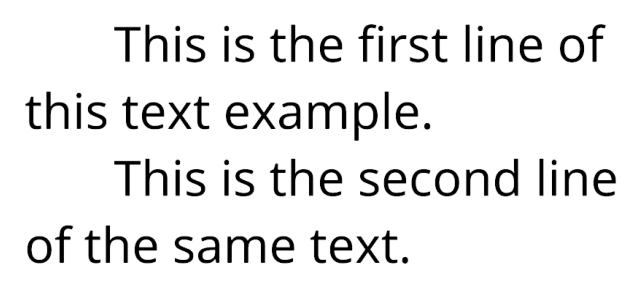


With Boxes:


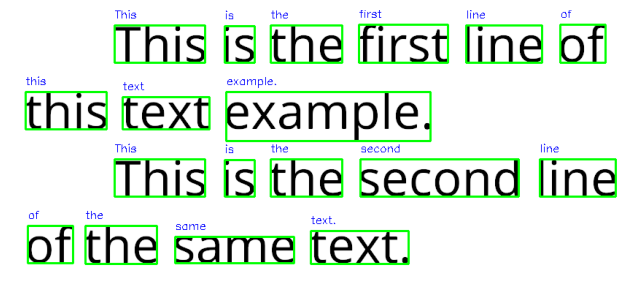


Extracted Text:
This is the first line of this text example. This is the second line of the same text.


In [17]:
# Load, preprocess, OCR, show

img_path = "C:\\Users\\vivek\\OneDrive\\Desktop\\DL Lab\\assignment_5\\test_image.png"
img = cv2.imread(img_path)

if img is None:
    print(f"Could not load image: {img_path}")
else:
    print("Original:")
    show(img)

    # 1) Preprocess
    pre = preprocess_image(img)

    # 2) OCR + boxes
    boxed, extracted = draw_tesseract_boxes(img, pre, psm=11)

    print("\nWith Boxes:")
    show(boxed)

    print("\nExtracted Text:")
    print(extracted)
